# Import Stuff

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.linalg import hankel



In [2]:
import numpy as np

def create_embedding(data):
    N = len(data)
    L = N // 2
    k = N - L + 1
    trajectory_matrix = np.zeros((L,k))
    c = 0
    for i in range(L):
        d = c
        for j in range(k):
            trajectory_matrix[i][j] = data[d]
            d = d + 1
        c = c + 1
    
    return trajectory_matrix, L

In [3]:
import numpy as np

def find_eig(data):
    eigenValues, eigenVectors = np.linalg.eig(np.dot(data, data.T))
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues, eigenVectors

In [4]:
import numpy as np

def project_onto_signal_subspace(data, eigenVectors, r):
    U, sigma, V = np.linalg.svd(data)
    V = V.T

    X_elem = np.array([sigma[i] * np.outer(U[:, i], V[:, i]) for i in range(0, r)])
    X_train_extracted = X_elem.sum(axis=0)
    X_train_extracted_data = np.asarray(list(X_train_extracted[:, 0]) + list(X_train_extracted[:, -1]))

    U = eigenVectors[:, :r]
    UT = U.T
    pX = np.matmul(UT, X_train_extracted)
    centroid = np.mean(pX, axis=1)
    centroid = centroid[:, np.newaxis]

    return centroid, pX, U, X_train_extracted_data

In [5]:
import numpy as np

def project_onto_signal_subspace_part2(data, eigenVectors, r):
    U, sigma, V = np.linalg.svd(data)
    V = V.T

    X_elem = np.array([sigma[i] * np.outer(U[:, i], V[:, i]) for i in range(0, r)])
    X_train_extracted = X_elem.sum(axis=0)
    X_train_extracted_data = np.asarray(list(X_train_extracted[:, 0]) + list(X_train_extracted[:, -1]))

    U = eigenVectors[:, :r]
    UT = U.T
    pX = np.matmul( UT, X_train_extracted)
    centroid = (np.min(pX, axis=1) + np.max(pX, axis=1))/2
    centroid = centroid[:, np.newaxis]

    return centroid, pX, U, X_train_extracted_data

In [6]:
import numpy as np
from scipy.linalg import hankel

def find_threshold(X_train, X_theta, U, centroid, L):
    Xtrain = hankel(X_train[:L], X_train[L-1:])
    UT = U.T
    pXtrain = np.matmul( UT, Xtrain)
    dtrain_matrix = centroid - pXtrain
    dtrain_scores = np.linalg.norm(dtrain_matrix, axis=0, ord=2)

    Xtheta = hankel(X_theta[:L], X_theta[L-1:])
    pXtheta = np.matmul(UT, Xtheta)
    dtest_matrix = centroid - pXtheta
    dtest_scores = np.linalg.norm(dtest_matrix, axis=0, ord=2)
    dtest_theta = np.max(dtest_scores)
    return dtest_theta, dtrain_scores, dtest_scores

In [7]:
import numpy as np
from scipy.linalg import hankel
import numpy as np
from scipy.linalg import hankel
from scipy.spatial.distance import mahalanobis

def find_threshold_part3(X_train, X_theta, U, centroid, L):

    # Create the Hankel matrix for training data
    Xtrain = hankel(X_train[:L], X_train[L-1:])
    
    # Project training data into the signal subspace
    UT = U.T
    pXtrain = np.matmul(UT, Xtrain)
    
    # Calculate the covariance matrix from the projected training data
    cov_matrix = np.cov(pXtrain, rowvar=True)
    
    # Invert the covariance matrix for Mahalanobis distance calculation
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Compute the Mahalanobis distance for training data
    dtrain_matrix = centroid - pXtrain
    dtrain_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dtrain_matrix), dtrain_matrix))
    
    # Now, handle the test data
    Xtheta = hankel(X_theta[:L], X_theta[L-1:])
    pXtheta = np.matmul(UT, Xtheta)
    
    # Compute the Mahalanobis distance for test data
    dtest_matrix = centroid - pXtheta
    dtest_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dtest_matrix), dtest_matrix))
    
    # Determine the maximum Mahalanobis distance in test data
    dtest_theta = np.max(dtest_scores)
    
    return dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix


In [8]:
import seaborn as sns
import pandas as pd
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np

def plot_stuff(type, xmeas, X_train_extracted_data, dtrg_scores, dt_scores, dj_scores, dt_theta, L, title):
    if(type==1):
        style.use('default')
        box = dict(facecolor='yellow', pad=3, alpha=0.2)
        fig = plt.figure(figsize=(10,7))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)

        ax1.set_xlim(0,len(xmeas) + 100)
        ax2.set_xlim(0,len(xmeas) + 100)

        plt.subplots_adjust(hspace=0.3)

        xlables = list(range(0, len(xmeas) + 100, 10))

        xmeasx_1 = list(range(501))
        xmeasx_2 = list(range(501, 2001))
        xmeasx_3 = list(range(2001,len(xmeas)))
        ax1.plot(xmeasx_1, xmeas[:501] ,'b', label='Training') 
        ax1.plot(xmeasx_2, xmeas[501:2001] ,'k', label='Threshold calculation') 
        ax1.plot(xmeasx_3, xmeas[2001:] ,'r', label='Detection')
        ax1.plot(X_train_extracted_data, 'g', linewidth=1, label='Extracted Signal' )
        ax1.set_xticklabels(xlables)
        ax1.title.set_text(title)
        ax1.set_ylabel('Sensor Reading', bbox=box)
        ylim = list(ax1.get_ylim())
        ax1.vlines(2000,ylim[0],ylim[1],linestyles='dashed', colors='r')
        X = np.array([[2000, len(xmeas) + 100],[2000, len(xmeas) + 100]])
        Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
        C = np.array([[2000]])
        print(X.shape, Y.shape, C.shape)
        ax1.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
        ax1.legend(loc='best', ncol=4)

        dy = dtrg_scores
        dx = list(range(L,len(dy)+L))
        ax2.plot(dx, dy, 'c', label='Training phase')
        dy = dt_scores
        dx = list(range(500,len(dy)+500))
        ax2.plot(dx, dy, 'b', label='Threshold calculation')
        dy = dj_scores
        dx = list(range(2000,len(dy)+2000))
        ax2.plot(dx, dy, 'r', label='Detection Phase')
        ylim = list(ax2.get_ylim())
        ax2.vlines(2000,ylim[0],ylim[1],linestyles='dashed', colors='r')
        ax2.set_xticklabels(xlables)
        ax2.hlines(dt_theta,0,len(xmeas) + 100,linestyles='dashed', label='Alarm Threshold')
        ax2.set_xlabel('Time in hours', bbox=box)
        ax2.set_ylabel('Departure Score', bbox=box)

        X = np.array([[2000, len(xmeas) + 100],[2000, len(xmeas) + 100]])
        Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
        C = np.array([[2000]])
        ax2.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
        ax2.legend(loc='upper left')
        fig.align_ylabels([ax1,ax2])
    elif(type==2):
        style.use('default')
        box = dict(facecolor='yellow', pad=3, alpha=0.2)
        fig = plt.figure(figsize=(10,7))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)

        ax1.set_xlim(0,len(xmeas) + 100)
        ax2.set_xlim(0,len(xmeas) + 100)

        plt.subplots_adjust(hspace=0.3)

        xlables = list(range(0, len(xmeas) + 100, 10))

        xmeasx_1 = list(range(10001))
        xmeasx_2 = list(range(10001, 496801))
        xmeasx_3 = list(range(496801, len(xmeas)))
        ax1.plot(xmeasx_1, xmeas[:10001] ,'b', label='Training') 
        ax1.plot(xmeasx_2, xmeas[10001:496801] ,'k', label='Threshold calculation') 
        ax1.plot(xmeasx_3, xmeas[496801:] ,'r', label='Detection')
        ax1.plot(X_train_extracted_data, 'g', linewidth=1, label='Extracted Signal' )
        ax1.set_xticklabels(xlables)
        ax1.title.set_text(title)
        ax1.set_ylabel('Sensor Reading', bbox=box)
        ylim = list(ax1.get_ylim())
        ax1.vlines(496800,ylim[0],ylim[1],linestyles='dashed', colors='r')
        X = np.array([[496800, len(xmeas) + 100],[496800, len(xmeas) + 100]])
        Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
        C = np.array([[496800]])
        print(X.shape, Y.shape, C.shape)
        ax1.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
        ax1.legend(loc='best', ncol=4)

        dy = dtrg_scores
        dx = list(range(L,len(dy)+L))
        ax2.plot(dx, dy, 'c', label='Training phase')
        dy = dt_scores
        dx = list(range(10000,len(dy)+10000))
        ax2.plot(dx, dy, 'b', label='Threshold calculation')
        dy = dj_scores
        dx = list(range(496800,len(dy)+496800))
        ax2.plot(dx, dy, 'r', label='Detection Phase')
        ylim = list(ax2.get_ylim())
        ax2.vlines(496800,ylim[0],ylim[1],linestyles='dashed', colors='r')
        ax2.set_xticklabels(xlables)
        ax2.hlines(dt_theta,0,len(xmeas) + 100,linestyles='dashed', label='Alarm Threshold')
        ax2.set_xlabel('Time in hours', bbox=box)
        ax2.set_ylabel('Departure Score', bbox=box)

        X = np.array([[496800, len(xmeas) + 100],[496800, len(xmeas) + 100]])
        Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
        C = np.array([[496800]])
        ax2.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
        ax2.legend(loc='upper left')
        fig.align_ylabels([ax1,ax2])

# Scenario DA1

In [9]:
X = np.asarray(pd.read_csv('sem 5/CS658/Pasad/xmv10_359_data_1.csv', usecols=[14], header=None))

In [10]:
print(X)
print(X.shape)
print(max(X), min(X))

[[50.095]
 [48.633]
 [50.497]
 ...
 [64.971]
 [62.78 ]
 [63.63 ]]
(4801, 1)
[66.896] [40.675]


In [11]:
X_train = X[:2000]
X_test = X[1750:]


In [12]:
print(X_train.shape, X_test.shape)

(2000, 1) (3051, 1)


In [13]:
X_train_initial = X_train[:500]
X_train_theta = X_train[250:]

In [14]:
X_train_new, L = create_embedding(X_train_initial)

C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\568833086.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trajectory_matrix[i][j] = data[d]


In [15]:
eigenValues, eigenVectors = find_eig(X_train_new)

### Plot after removing the 1st EigenValue

Text(0.5, 1.02, 'Scree Plot')

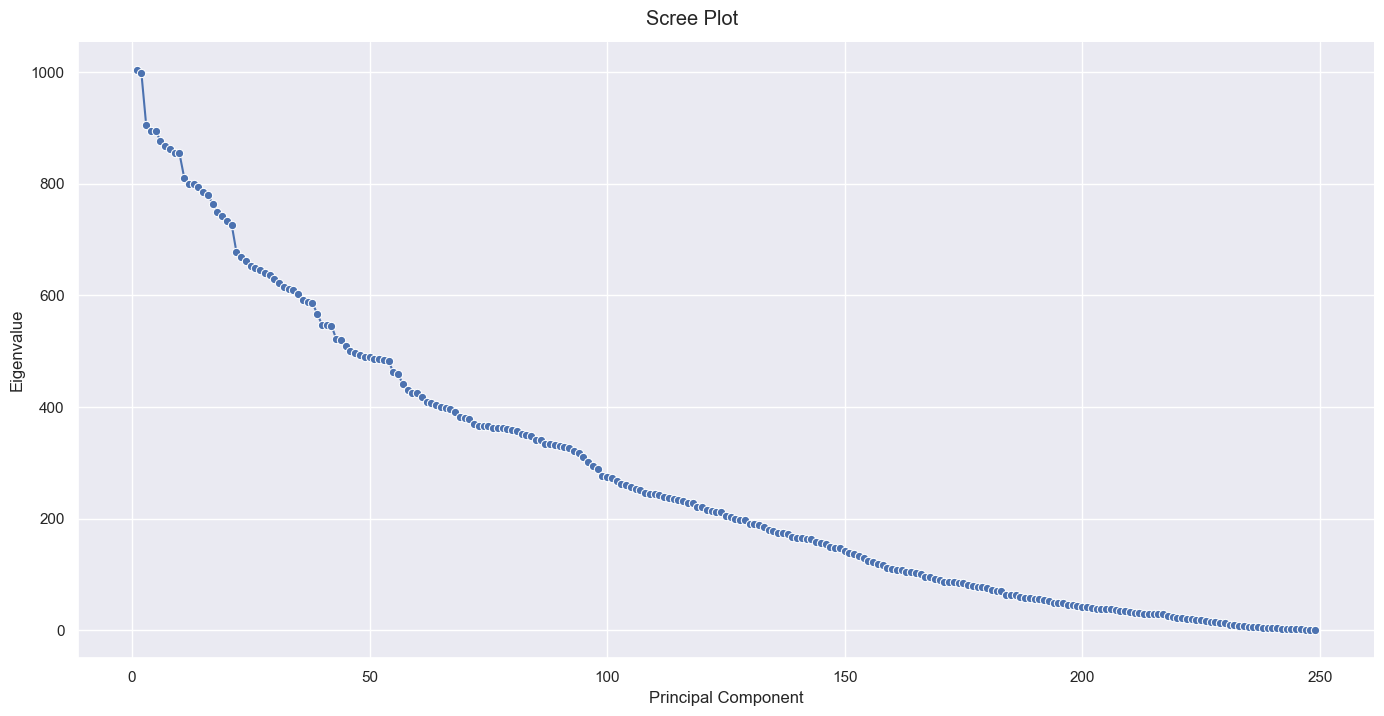

In [16]:
temp_df = pd.DataFrame({
    'Principal Component': range(1, len(eigenValues)),
    'Eigenvalue': eigenValues[1:]
})

sns.set_theme()

plot = sns.relplot(data=temp_df, x='Principal Component', y='Eigenvalue', kind='line', marker='o', height=7, aspect=2)

plot.set_axis_labels("Principal Component", "Eigenvalue")
plot.figure.suptitle("Scree Plot", y=1.02)

### Using our criteria of maximum consecutive difference

In [17]:
diff = np.diff(eigenValues[1:])

elbow_index = np.argmin(diff) + 1

print(f"The elbow is at component {elbow_index}")
print(f"The value of r: {elbow_index + 1}")

The elbow is at component 2
The value of r: 3


In [18]:
r = elbow_index + 1

In [19]:
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace(X_train_new, eigenVectors, r)

In [20]:
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)

In [21]:
th1 = dtest_theta
print(dtest_theta)

4.501286770068838


In [22]:
Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count = np.zeros(5)
alarm_count[0] = np.sum(dj_scores > th1)
np.max(dj_scores)

72.96927917874088

In [23]:
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)

In [24]:
th1 = dtest_theta
print(dtest_theta)

3.1675585194734155


In [25]:
Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count3 = np.zeros(5)
alarm_count3[0] = np.sum(dj_scores > th1)
np.max(dj_scores)


53.89588809981044

In [26]:
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace_part2(X_train_new, eigenVectors, r)

In [27]:
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)

In [28]:
th1 = dtest_theta
print(dtest_theta)

4.554624900863989


In [29]:
Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count2 = np.zeros(5)
alarm_count2[0] = np.sum(dj_scores > th1)
np.max(dj_scores)


72.60995293923341

In [30]:
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)

In [31]:
th1 = dtest_theta
print(dtest_theta)

2.9359664795440694


In [32]:
Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)  
dj_matrix = centroid - pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count4 = np.zeros(5)
alarm_count4[0] = np.sum(dj_scores > th1)
np.max(dj_scores)

53.639537028029565

C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xlables)
C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlables)


(2, 2) (2, 2) (1, 1)


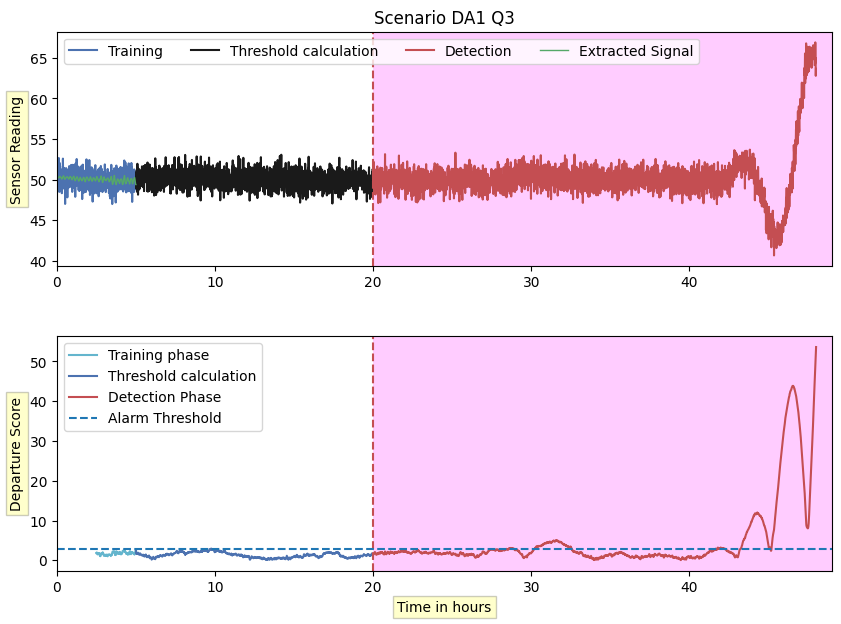

In [33]:
plot_stuff(1, X, X_train_extracted_data, dtrain_scores, dtest_scores, dj_scores, dtest_theta, L, "Scenario DA1 Q3")

# Scenario DA2

In [34]:
X = np.asarray(pd.read_csv('sem 5/CS658/Pasad/xmeas7_zero_data_1.csv', usecols=[1], header=None))

In [35]:
print(X)
print(X.shape)
print(max(X), min(X))

[[3664.3]
 [3641.3]
 [3688.2]
 ...
 [3641.2]
 [3651.4]
 [3631.7]]
(4801, 1)
[3726.4] [3595.3]


### Plot after removing the 1st EigenValue

C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\568833086.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trajectory_matrix[i][j] = data[d]


Text(0.5, 1.02, 'Scree Plot')

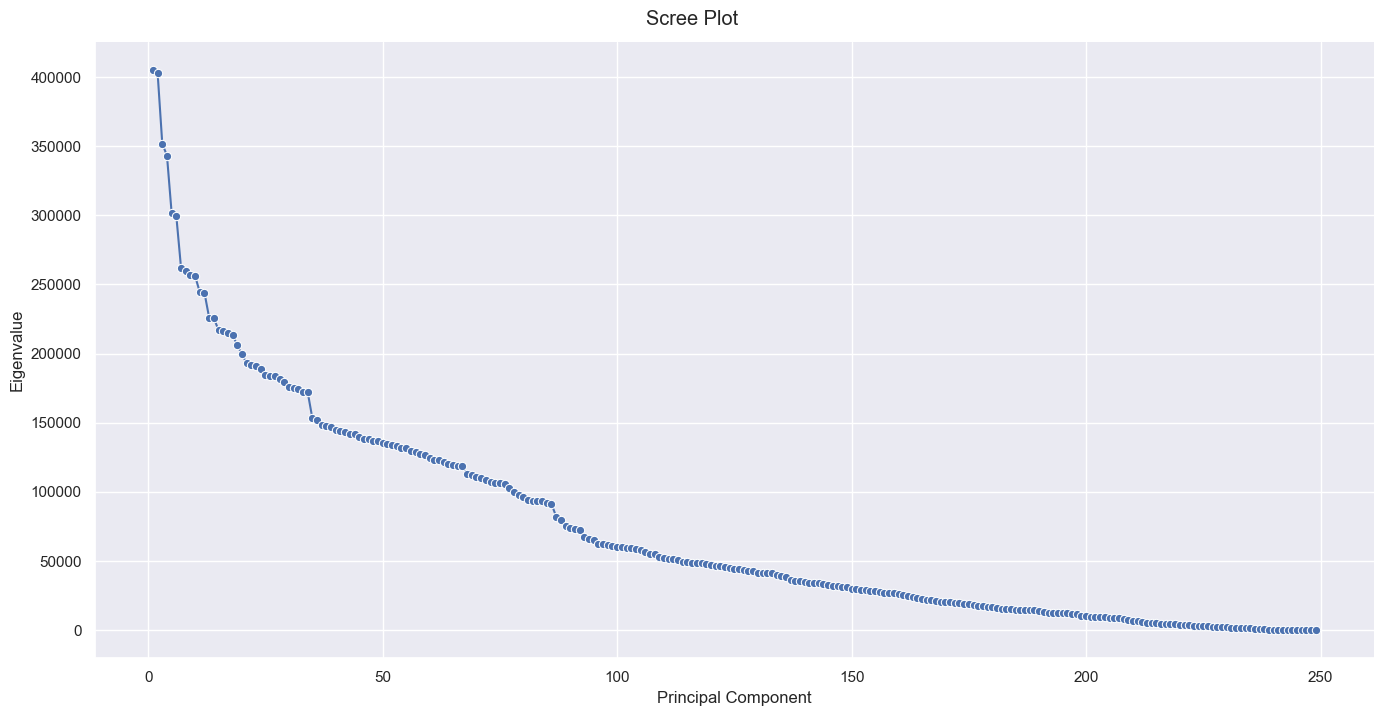

In [36]:
X_train = X[:2000]
X_test = X[1750:]

X_train_initial = X_train[:500]
X_train_theta = X_train[250:]

# Step 1
X_train_new, L = create_embedding(X_train_initial)

# Step 2
eigenValues, eigenVectors = find_eig(X_train_new)

# Scree Plot
temp_df = pd.DataFrame({
    'Principal Component': range(1, len(eigenValues)),
    'Eigenvalue': eigenValues[1:]
})

sns.set_theme()

plot = sns.relplot(data=temp_df, x='Principal Component', y='Eigenvalue', kind='line', marker='o', height=7, aspect=2)

plot.set_axis_labels("Principal Component", "Eigenvalue")
plot.figure.suptitle("Scree Plot", y=1.02)

### Using our criteria of maximum consecutive difference

In [37]:
diff = np.diff(eigenValues[1:])

elbow_index = np.argmin(diff) + 1

print(f"The elbow is at component {elbow_index}")
print(f"The value of r: {elbow_index + 1}")

The elbow is at component 2
The value of r: 3


In [38]:
r = elbow_index + 1

# Step 3
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count[1] = np.sum(dj_scores > th2)
np.max(dj_scores)



66.27082701805655


360.43107643651103

6.574599621711618
(2, 2) (2, 2) (1, 1)


C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xlables)
C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlables)


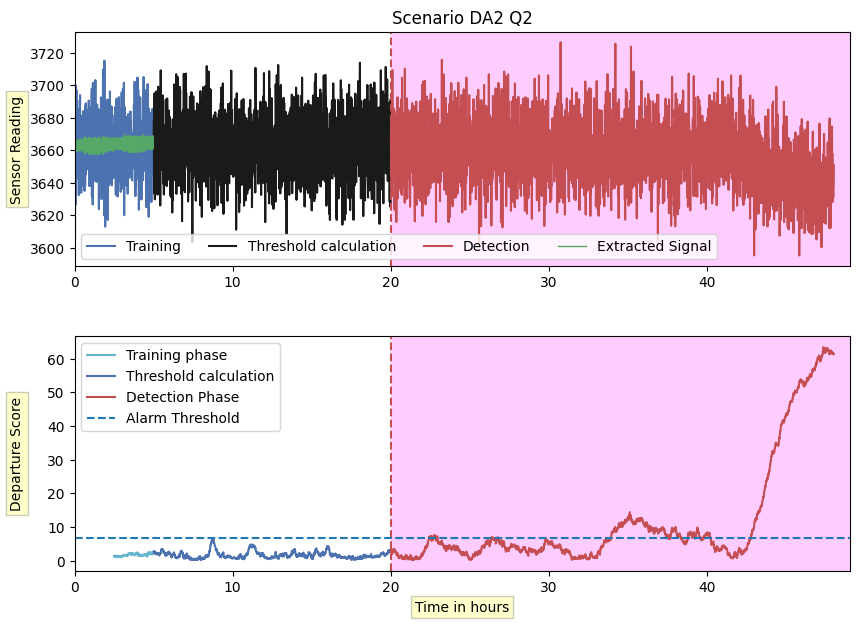

In [39]:
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count3[1] = np.sum(dj_scores > th2)
np.max(dj_scores)

plot_stuff(1, X, X_train_extracted_data, dtrain_scores, dtest_scores, dj_scores, dtest_theta, L, "Scenario DA2 Q2")

In [40]:
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace_part2(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count2[1] = np.sum(dj_scores > th2)
np.max(dj_scores)


65.83646854682766


361.8431398527127

6.335435468129759
(2, 2) (2, 2) (1, 1)


C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xlables)
C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlables)


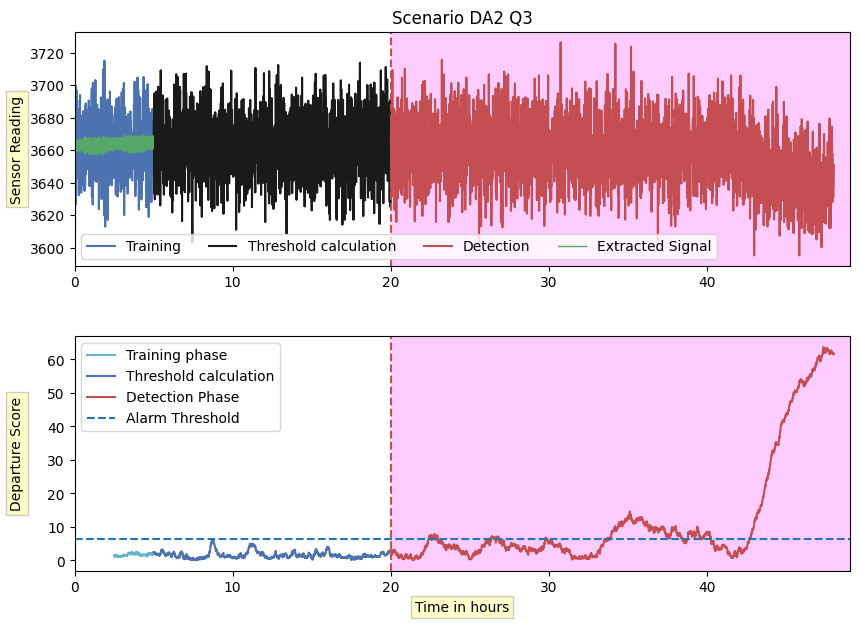

In [41]:
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count4[1] = np.sum(dj_scores > th2)
np.max(dj_scores)

plot_stuff(1, X, X_train_extracted_data, dtrain_scores, dtest_scores, dj_scores, dtest_theta, L, "Scenario DA2 Q3")

# Scenario SA1

In [42]:
X = np.asarray(pd.read_csv('sem 5/CS658/Pasad/xmv9_hundred_data_1.csv', usecols=[1], header=None))

In [43]:
print(X)
print(X.shape)
print(max(X), min(X))

[[3664.3]
 [3667.7]
 [3688.9]
 ...
 [3579.9]
 [3576.4]
 [3597.2]]
(4801, 1)
[3729.4] [3550.]


### Plot after removing the 1st EigenValue

C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\568833086.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trajectory_matrix[i][j] = data[d]


Text(0.5, 1.02, 'Scree Plot')

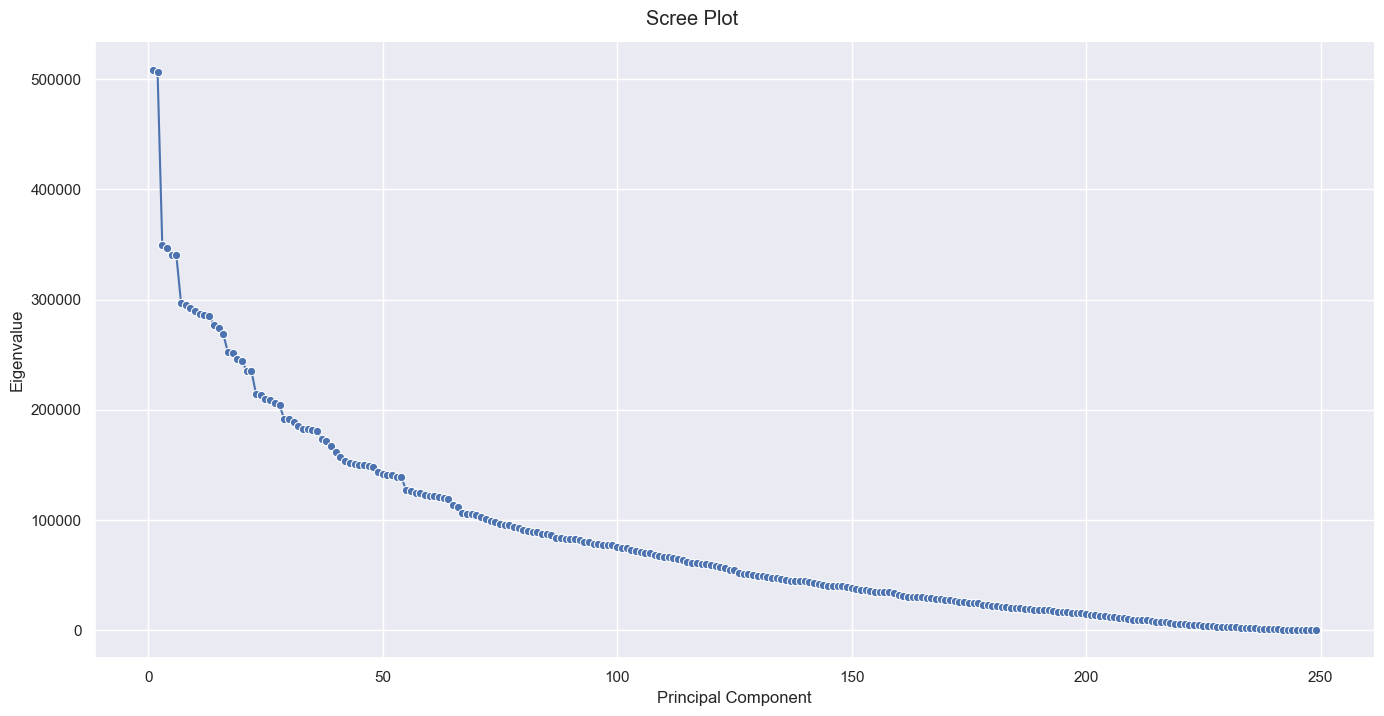

In [44]:
X_train = X[:2000]
X_test = X[1750:]

X_train_initial = X_train[:500]
X_train_theta = X_train[250:]

# Step 1
X_train_new, L = create_embedding(X_train_initial)

# Step 2
eigenValues, eigenVectors = find_eig(X_train_new)

# Scree Plot
temp_df = pd.DataFrame({
    'Principal Component': range(1, len(eigenValues)),
    'Eigenvalue': eigenValues[1:]
})

sns.set_theme()

plot = sns.relplot(data=temp_df, x='Principal Component', y='Eigenvalue', kind='line', marker='o', height=7, aspect=2)

plot.set_axis_labels("Principal Component", "Eigenvalue")
plot.figure.suptitle("Scree Plot", y=1.02)

### Using our criteria of maximum consecutive difference

In [45]:
diff = np.diff(eigenValues[1:])

elbow_index = np.argmin(diff) + 1

print(f"The elbow is at component {elbow_index}")
print(f"The value of r: {elbow_index + 1}")

The elbow is at component 2
The value of r: 3


In [46]:
r = elbow_index + 1

# Step 3
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th3 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count[2] = np.sum(dj_scores > th3)
np.max(dj_scores)



77.90911848768103


1152.819208969869

In [47]:
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count3[2] = np.sum(dj_scores > th2)
np.max(dj_scores)

16.86253643153581


261.499961184649

In [48]:
# Step 3
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace_part2(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th3 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count2[2] = np.sum(dj_scores > th3)
np.max(dj_scores)



80.31554061077529


1153.7338240676654

17.10536214944496
(2, 2) (2, 2) (1, 1)


C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xlables)
C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlables)


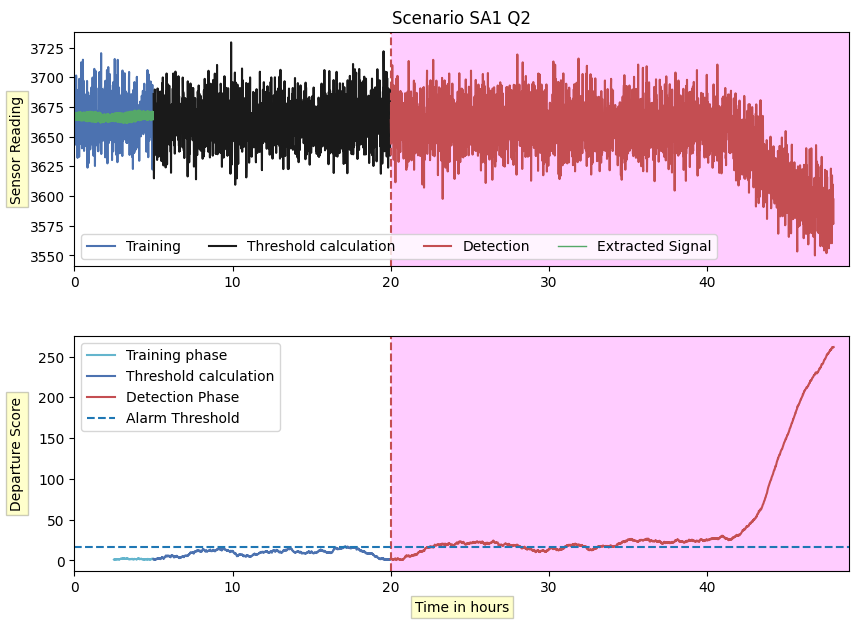

In [49]:
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count4[2] = np.sum(dj_scores > th2)
np.max(dj_scores)
plot_stuff(1, X, X_train_extracted_data, dtrain_scores, dtest_scores, dj_scores, dtest_theta, L, "Scenario SA1 Q2")

# Scenario SA2

In [50]:
X = np.asarray(pd.read_csv('sem 5/CS658/Pasad/xmv6_twentyeight_data_1.csv', usecols=[6], header=None))

In [51]:
print(X)
print(f"Shape of X: {X.shape}")
print(f"Maximum value: {max(X)}, Minimum value: {min(X)}")

[[2799.1]
 [2799.6]
 [2799.8]
 ...
 [2783.2]
 [2784.7]
 [2784.1]]
Shape of X: (4801, 1)
Maximum value: [2804.3], Minimum value: [2783.2]


### Plot after removing the 1st EigenValue

C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\568833086.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trajectory_matrix[i][j] = data[d]


Text(0.5, 1.02, 'Scree Plot')

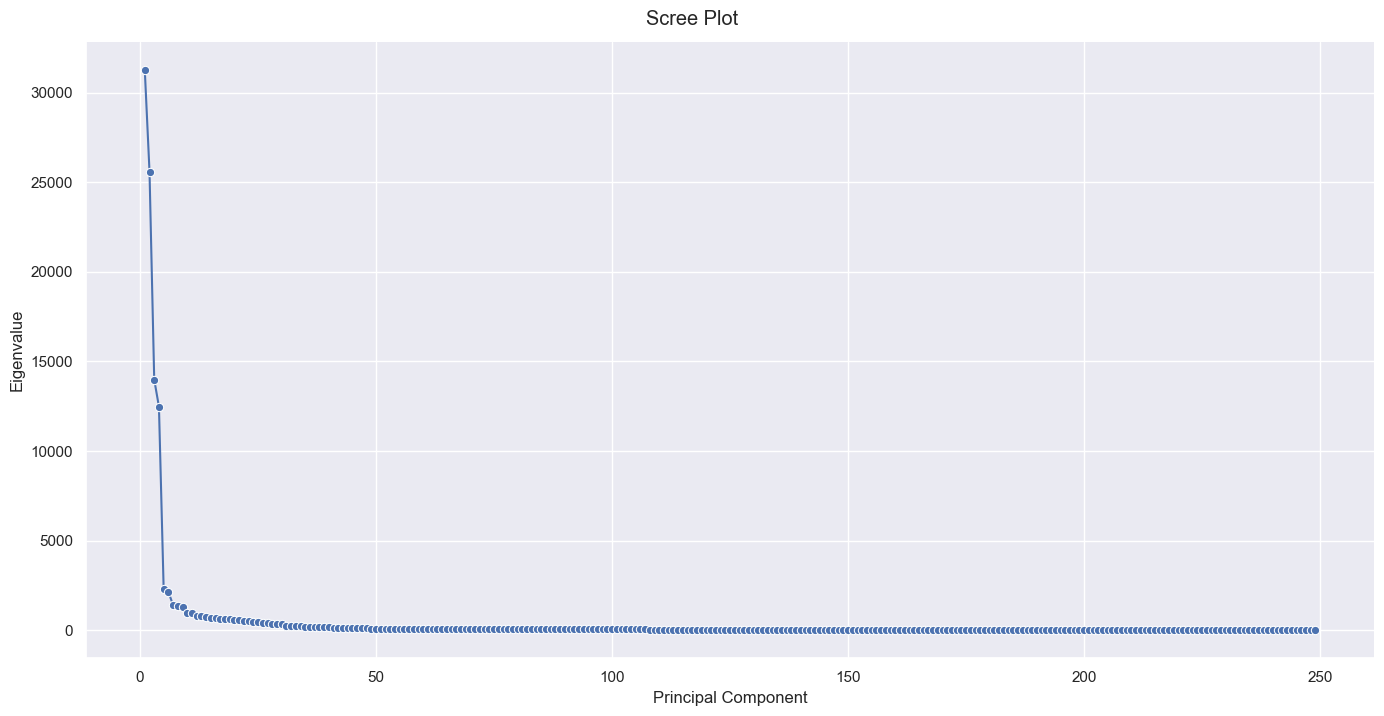

In [52]:
X_train = X[:2000]
X_test = X[1750:]

X_train_initial = X_train[:500]
X_train_theta = X_train[250:]

# Step 1
X_train_new, L = create_embedding(X_train_initial)

# Step 2
eigenValues, eigenVectors = find_eig(X_train_new)

# Scree Plot
temp_df = pd.DataFrame({
    'Principal Component': range(1, len(eigenValues)),
    'Eigenvalue': eigenValues[1:]
})

sns.set_theme()

plot = sns.relplot(data=temp_df, x='Principal Component', y='Eigenvalue', kind='line', marker='o', height=7, aspect=2)

plot.set_axis_labels("Principal Component", "Eigenvalue")
plot.figure.suptitle("Scree Plot", y=1.02)

### Using our criteria of maximum consecutive difference

In [53]:
diff = np.diff(eigenValues[1:])

elbow_index = np.argmin(diff) + 1

print(f"The elbow is at component {elbow_index}")
print(f"The value of r: {elbow_index + 1}")

The elbow is at component 2
The value of r: 3


In [54]:
r = elbow_index + 1

# Step 3
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th4 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count[3] = np.sum(dj_scores > th4)
np.max(dj_scores)

dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count3[3] = np.sum(dj_scores > th2)
np.max(dj_scores)

16.29717596207836
3.7459936466139636


124.59744457453621

17.946728687414844
4.072738449562585
(2, 2) (2, 2) (1, 1)


C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xlables)
C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlables)


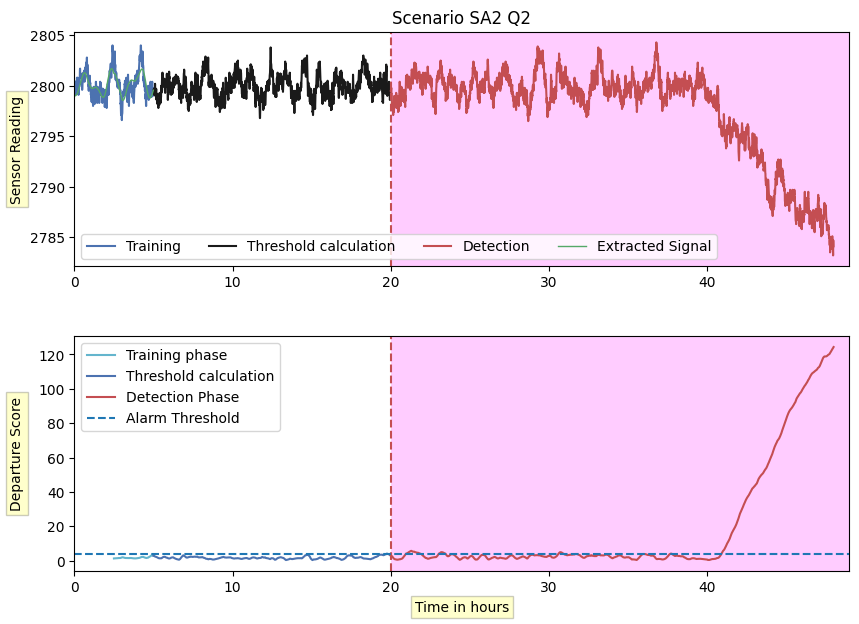

In [55]:
# Step 3
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace_part2(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th4 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count2[3] = np.sum(dj_scores > th4)
np.max(dj_scores)
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count4[3] = np.sum(dj_scores > th2)
np.max(dj_scores)

plot_stuff(1, X, X_train_extracted_data, dtrain_scores, dtest_scores, dj_scores, dtest_theta, L, "Scenario SA2 Q2")

# Scenario SA3

In [56]:
X = np.asarray(pd.read_csv('sem 5/CS658/Pasad/xmeas10_001_data_1.csv', usecols=[9], header=None))

In [57]:
print(X)
print(f"Shape of X: {X.shape}")
print(f"Maximum value: {max(X)}, Minimum value: {min(X)}")

[[0.19833]
 [0.19818]
 [0.19796]
 ...
 [0.15563]
 [0.15788]
 [0.15627]]
Shape of X: (4801, 1)
Maximum value: [0.44692], Minimum value: [0.15506]


### Plot after removing the 1st EigenValue

C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\568833086.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trajectory_matrix[i][j] = data[d]


Text(0.5, 1.02, 'Scree Plot')

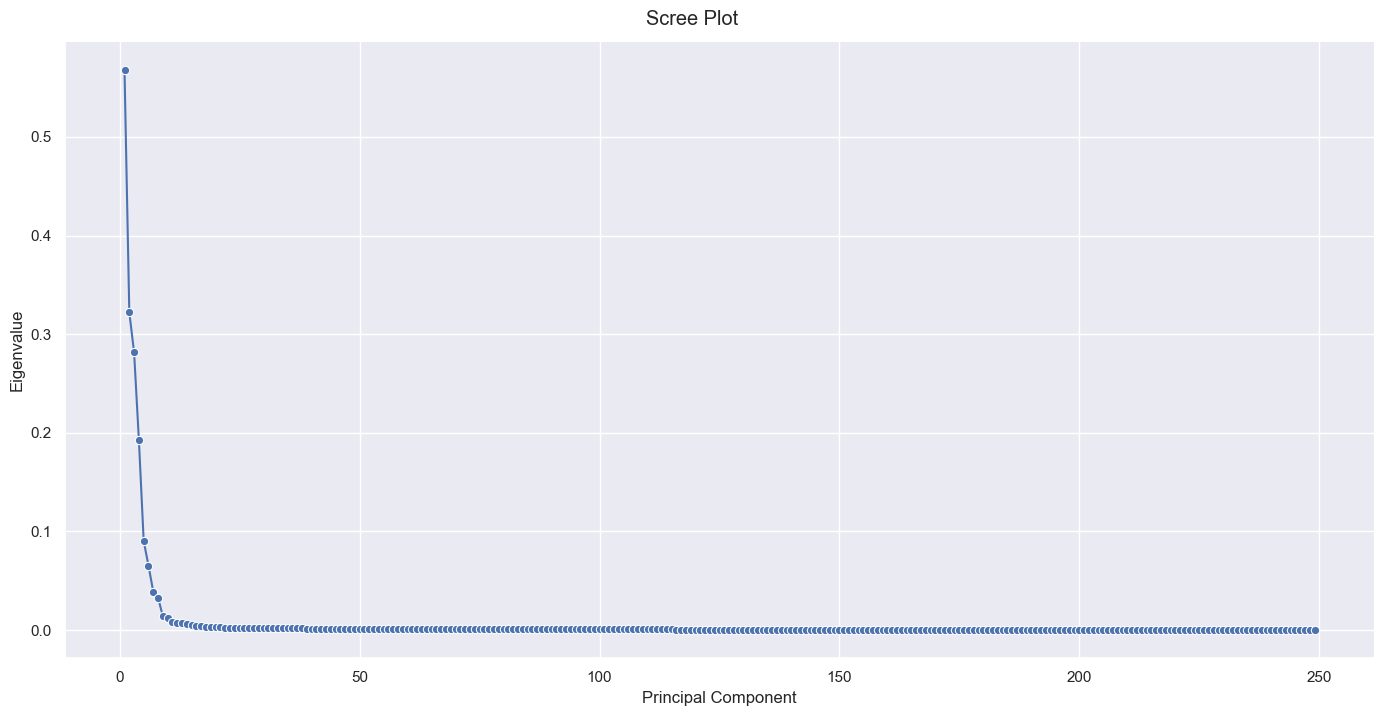

In [58]:
X_train = X[:2000]
X_test = X[1750:]

X_train_initial = X_train[:500]
X_train_theta = X_train[250:]

# Step 1
X_train_new, L = create_embedding(X_train_initial)

# Step 2
eigenValues, eigenVectors = find_eig(X_train_new)

# Scree Plot
temp_df = pd.DataFrame({
    'Principal Component': range(1, len(eigenValues)),
    'Eigenvalue': eigenValues[1:]
})

sns.set_theme()

plot = sns.relplot(data=temp_df, x='Principal Component', y='Eigenvalue', kind='line', marker='o', height=7, aspect=2)

plot.set_axis_labels("Principal Component", "Eigenvalue")
plot.figure.suptitle("Scree Plot", y=1.02)

### Using our criteria of maximum consecutive difference

In [59]:
diff = np.diff(eigenValues[1:])

elbow_index = np.argmin(diff) + 1

print(f"The elbow is at component {elbow_index}")
print(f"The value of r: {elbow_index + 1}")

The elbow is at component 1
The value of r: 2


In [60]:
r = elbow_index + 1

# Step 3
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th5 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count[4] = np.sum(dj_scores > th5)
np.max(dj_scores)

dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count3[4] = np.sum(dj_scores > th2)
np.max(dj_scores)

0.222398559888916
4.665932278589904


69.20726101581097

0.2358011618100961
4.697355674677192
(2, 2) (2, 2) (1, 1)


C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xlables)
C:\Users\lky24\AppData\Local\Temp\ipykernel_20376\323365824.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlables)


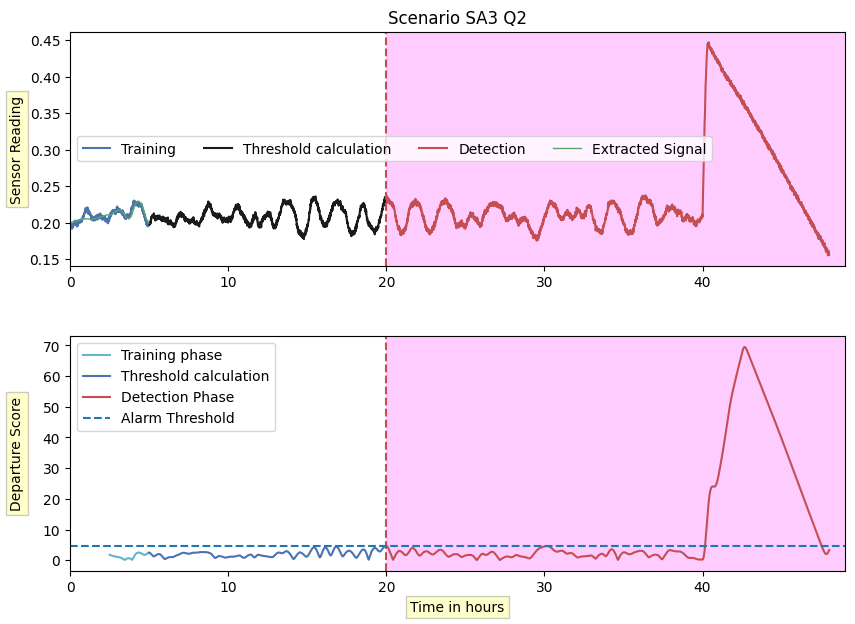

In [61]:
centroid, pX, U, X_train_extracted_data = project_onto_signal_subspace_part2(X_train_new, eigenVectors, r)

# Step 4
dtest_theta, dtrain_scores, dtest_scores = find_threshold(X_train_initial, X_train_theta, U, centroid, L)
th5 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
dj_scores = np.asarray(dj_scores)
alarm_count2[4] = np.sum(dj_scores > th5)
np.max(dj_scores)
dtest_theta, dtrain_scores, dtest_scores, inv_cov_matrix = find_threshold_part3(X_train_initial, X_train_theta, U, centroid, L)
th2 = dtest_theta
print(dtest_theta)

Xj = hankel(X_test[:L], X_test[L-1:])
UT = U.T
pXj = np.matmul( UT, Xj)
dj_matrix =centroid- pXj
dj_scores = np.sqrt(np.einsum('ij,ij->j', np.dot(inv_cov_matrix, dj_matrix), dj_matrix))
dj_scores = np.asarray(dj_scores)
alarm_count4[4] = np.sum(dj_scores > th2)
np.max(dj_scores)
plot_stuff(1, X, X_train_extracted_data, dtrain_scores, dtest_scores, dj_scores, dtest_theta, L, "Scenario SA3 Q2")

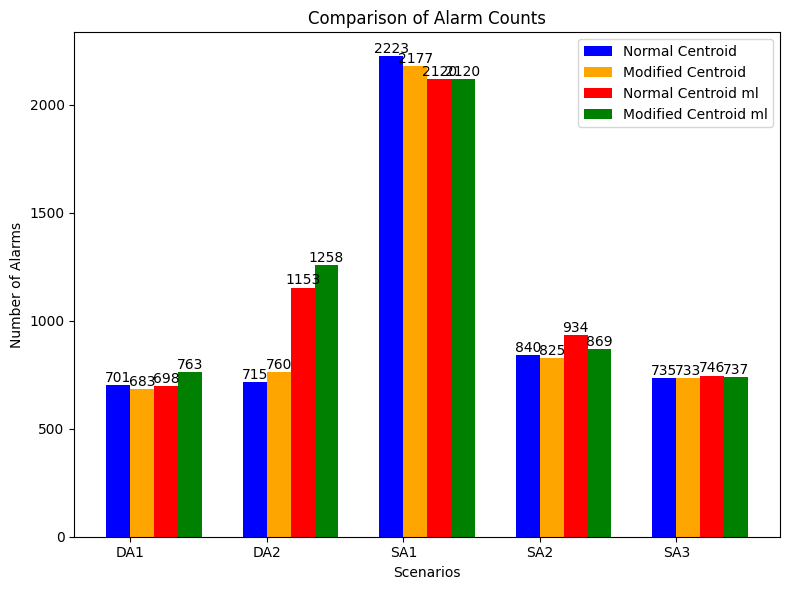

In [62]:
# Example data
categories = ['DA1', 'DA2', 'SA1', 'SA2', 'SA3']  # Replace with your actual categories

# Define the width of the bars
bar_width = 0.35

# Define the positions for the groups
index = np.arange(len(categories))

# Create the bar plot
plt.figure(figsize=(8, 6))
bars1 = plt.bar(index, alarm_count, bar_width/2, label='Normal Centroid', color='blue')
bars2 = plt.bar(index + bar_width/2, alarm_count2, bar_width/2, label='Modified Centroid', color='orange')
bars3 = plt.bar(index+2*bar_width/2, alarm_count3, bar_width/2, label='Normal Centroid ml', color='red')
bars4 = plt.bar(index + 3*bar_width/2, alarm_count4, bar_width/2, label='Modified Centroid ml', color='green')

# Add labels and title
plt.xlabel('Scenarios')
plt.ylabel('Number of Alarms')
plt.title('Comparison of Alarm Counts')
plt.xticks(index + bar_width / 4, categories)  # Center the labels between the bars
plt.legend()

# Add value labels on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')
    
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')
for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')
    
for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()
